# **DỰ BÁO GIÁ CHỨNG KHOÁN**

Đoạn mã dưới đây bao gồm các bước sử dụng mô hình RNN đơn biến để dự báo giá chứng khoán của Công ty Cổ phần Viễn thông FPT:

1. Thu thập dữ liệu từ thư viện vnstock và tiến hành tiền xử lý dữ liệu.

2. Chuẩn bị dữ liệu huấn luyện.

3. Xây dựng mô hình RNN.

4. Tối ưu hóa tham số mô hình bằng phương pháp Bayesian.

5. Huấn luyện mô hình với tham số tối ưu.

6. Đánh giá mô hình qua các chỉ số đánh giá MSE, RMSE, MAPE, R².

7. Đánh giá kết quả thông qua biểu đồ trực quan.

#CHUẨN BỊ CÁC THƯ VIỆN

In [ ]:
!pip install vnstock
!pip install vnstock3 --upgrade
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import sys
import optuna
import seaborn as sns
np.random.seed(1)
import datetime as dt
import time
import tensorflow as tf
tf.random.set_seed(2)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Lấy dữ liệu từ thư viện vnstock
from vnstock import Quote


    Khi tiếp tục sử dụng Vnstock3, bạn xác nhận rằng bạn đã đọc, hiểu và đồng ý với Chính sách quyền riêng tư và Điều khoản, điều kiện về giấy phép sử dụng Vnstock3.

    Chi tiết:

    - Giấy phép sử dụng phần mềm: https://vnstocks.com/docs/tai-lieu/giay-phep-su-dung
    - Chính sách quyền riêng tư: https://vnstocks.com/docs/tai-lieu/chinh-sach-quyen-rieng-tu
    


#TIỀN XỬ LÝ DỮ LIỆU

Lấy dữ liệu

In [ ]:
# Lấy dữ liệu giá cổ phiếu FPT từ vnstock
quote = Quote(symbol="FPT", source="VCI")
start_date = "2019-11-20"
end_date = "2024-11-20"
data = quote.history(start=start_date, end=end_date)

df = pd.DataFrame(data)
print(data)


           time    open    high     low   close   volume
0    2019-11-20   24.64   24.64   23.96   24.05  2291760
1    2019-11-21   24.05   24.18   23.67   23.71  3303950
2    2019-11-22   23.84   24.18   23.50   23.71  1625820
3    2019-11-25   23.75   24.13   23.62   23.96  1087990
4    2019-11-26   24.13   24.22   24.05   24.18   968690
...         ...     ...     ...     ...     ...      ...
1247 2024-11-15  134.37  134.76  131.69  132.98  6574421
1248 2024-11-18  133.08  133.67  131.59  133.08  3910975
1249 2024-11-19  132.58  132.68  129.00  129.10  7652727
1250 2024-11-20  129.10  131.49  125.83  131.49  8474055
1251 2024-11-21  131.49  132.08  130.10  132.08  3183165

[1252 rows x 6 columns]


Kiểm tra dữ liệu

In [ ]:
# Bảng thống kê mô tả của bộ dữ liệu
print("Bảng thống kê mô tả dữ liệu:")
print(df.describe())

Bảng thống kê mô tả dữ liệu:
                                time         open         high          low  \
count                           1252  1252.000000  1252.000000  1252.000000   
mean   2022-05-23 08:18:01.150159616    60.869944    61.537252    60.242899   
min              2019-11-20 00:00:00    17.150000    17.400000    16.980000   
25%              2021-02-22 18:00:00    38.487500    38.737500    37.777500   
50%              2022-05-25 12:00:00    57.270000    57.780000    56.750000   
75%              2023-08-22 06:00:00    72.862500    73.512500    71.672500   
max              2024-11-21 00:00:00   141.020000   141.810000   138.640000   
std                              NaN    31.234993    31.529763    30.945988   

             close        volume  
count  1252.000000  1.252000e+03  
mean     60.901965  2.250233e+06  
min      17.100000  2.219660e+05  
25%      38.437500  1.173650e+06  
50%      57.145000  1.830030e+06  
75%      72.900000  2.762853e+06  
max     140.72

In [ ]:
# Kiểm tra giá trị null, trùng lặp
print("Số lượng giá trị null trong dữ liệu:")
print(df.isnull().sum())
print("Số lượng bản ghi trùng lặp:", df.duplicated().sum())

Số lượng giá trị null trong dữ liệu:
time      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64
Số lượng bản ghi trùng lặp: 0


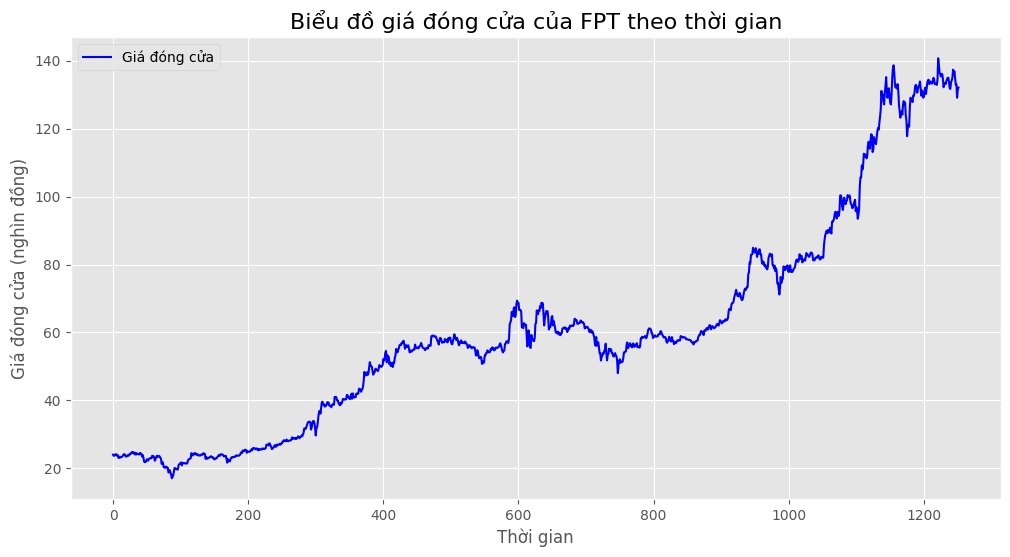

In [ ]:
# Trực quan hóa dữ liệu giá đóng cửa theo thời gian
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['close'], color='blue', label='Giá đóng cửa')
plt.title(f'Biểu đồ giá đóng cửa của {quote.symbol} theo thời gian', fontsize=16)
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('Giá đóng cửa (nghìn đồng)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

  Variable  Correlation with Close
0     open                0.999454
1     high                0.999762
2      low                0.999697
3   volume                0.454607


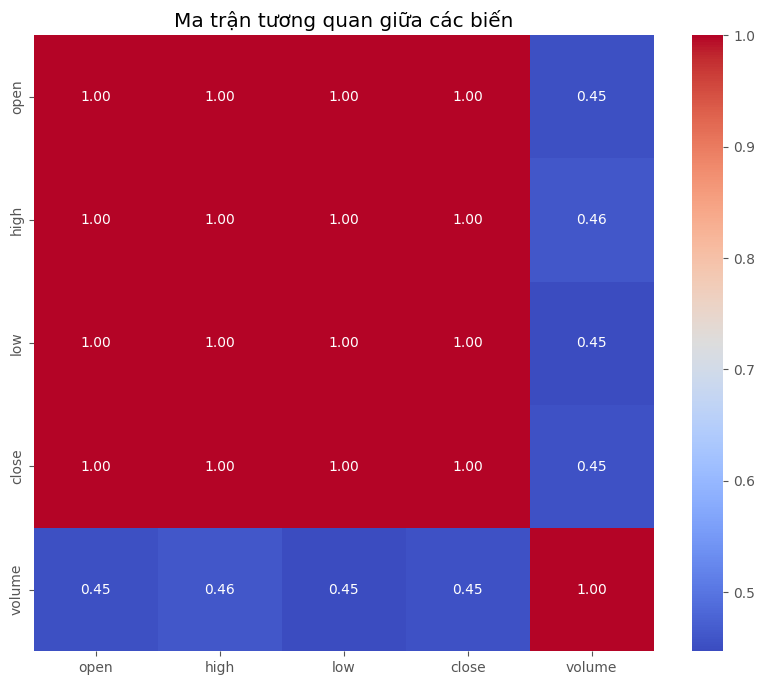

In [ ]:
# Tính toán mức độ tương quan giữa các biến
correlation_with_close = df[['open', 'high', 'low', 'close', 'volume']].corr()['close']
correlation_with_close = correlation_with_close.drop('close')

correlation_table = pd.DataFrame(correlation_with_close).reset_index()
correlation_table.columns = ['Variable', 'Correlation with Close']
print(correlation_table)

plt.figure(figsize=(10, 8))
sns.heatmap(df[['open', 'high', 'low', 'close', 'volume']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Ma trận tương quan giữa các biến')
plt.show()

Xử lý dữ liệu

In [ ]:
# Chuyển đổi dữ liệu về dạng DataFrame và xử lý
if df is not None:
    df = pd.DataFrame(df)
    df.set_index('time', inplace=True)
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
else:
    raise ValueError("Không thể lấy dữ liệu từ vnstock. Vui lòng kiểm tra kết nối hoặc mã cổ phiếu.")

# Loại bỏ các hàng có volume = 0
df.drop(df[df['volume'] == 0].index, inplace=True)

In [ ]:
# Chọn biến huấn luyện
series = df[['close', 'high', 'volume']]

# Chia dữ liệu thành các tập Train, Validation và Test
train_data = series.loc["2019-11-20":"2022-11-20"].values.reshape(-1, 1)
val_data = series.loc["2022-11-21":"2023-11-20"].values.reshape(-1, 1)
test_data = series.loc["2023-11-21":"2024-11-20"].values.reshape(-1, 1)

# Chuẩn hoá dữ liệu
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

#XÂY DỰNG MÔ HÌNH

Xây dựng và huấn luyện mô hình trên tập train và validation

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80, verbose=1, mode='min')
callbacks_list = [earlystop]

def fit_model(train, val, timesteps, hl, lr, batch, epochs):
    X_train, Y_train, X_val, Y_val = [], [], [], []

    # Chuẩn bị dữ liệu train
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Chuẩn bị dữ liệu validation
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xây dựng mô hình
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate = lr), loss = 'mean_squared_error')

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False)
    return model, history.history['loss'], history.history['val_loss']


Đánh giá và dự đoán trên tập test

In [ ]:
def evaluate_model(model, test, timesteps):
    X_test = []
    Y_test = []

    # Chuẩn bị dữ liệu test
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Dự đoán
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

Tối ưu hoá các tham số

In [ ]:
# Tối ưu hoá các tham số bằng Bayesian Optimization
def objective(trial):
    timesteps = trial.suggest_int('timesteps', 20, 60, step=10)
    hl = [trial.suggest_int(f'hl_{i}', 20, 50, step=5) for i in range(2)]
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 50, 300, step=50)

    model, train_loss, val_loss = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs)
    mse, rmse, mape, r2, _, _ = evaluate_model(model, test, timesteps)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)

[I 2025-01-04 02:07:51,096] A new study created in memory with name: no-name-80fbe496-d0e4-40f9-b3cc-786974acb64f
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2025-01-04 02:09:43,699] Trial 0 finished with value: 0.004522959259301681 and parameters: {'timesteps': 20, 'hl_0': 30, 'hl_1': 20, 'lr': 0.00012612305368281477, 'batch_size': 32, 'num_epochs': 300}. Best is trial 0 with value: 0.004522959259301681.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-01-04 02:12:53,291] Trial 1 finished with value: 0.02576417904395048 and parameters: {'timesteps': 50, 'hl_0': 20, 'hl_1': 25, 'lr': 0.005241937675956987, 'batch_size': 16, 'num_epochs': 150}. Best is trial 0 with value: 0.004522959259301681.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


[I 2025-01-04 02:13:53,490] Trial 2 finished with value: 0.006466188931835785 and parameters: {'timesteps': 40, 'hl_0': 40, 'hl_1': 20, 'lr': 0.0006037348666638009, 'batch_size': 128, 'num_epochs': 250}. Best is trial 0 with value: 0.004522959259301681.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-01-04 02:14:14,479] Trial 3 finished with value: 0.005869421340356973 and parameters: {'timesteps': 20, 'hl_0': 45, 'hl_1': 35, 'lr': 0.00018824907603212743, 'batch_size': 32, 'num_epochs': 50}. Best is trial 0 with value: 0.004522959259301681.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


[I 2025-01-04 02:15:14,734] Trial 4 finished with value: 0.0028040575854645935 and parameters: {'timesteps': 30, 'hl_0': 30, 'hl_1': 20, 'lr': 0.0015144088828060358, 'batch_size': 128, 'num_epochs': 300}. Best is trial 4 with value: 0.0028040575854645935.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


[I 2025-01-04 02:19:17,659] Trial 5 finished with value: 0.04194387687513091 and parameters: {'timesteps': 40, 'hl_0': 50, 'hl_1': 25, 'lr': 0.0022115613743007904, 'batch_size': 16, 'num_epochs': 200}. Best is trial 4 with value: 0.0028040575854645935.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-01-04 02:23:34,089] Trial 6 finished with value: 0.05007712966949322 and parameters: {'timesteps': 50, 'hl_0': 20, 'hl_1': 50, 'lr': 0.008229334427644095, 'batch_size': 16, 'num_epochs': 200}. Best is trial 4 with value: 0.0028040575854645935.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-01-04 02:25:42,973] Trial 7 finished with value: 0.2095118994850584 and parameters: {'timesteps': 50, 'hl_0': 20, 'hl_1': 40, 'lr': 0.006648663703560268, 'batch_size': 16, 'num_epochs': 100}. Best is trial 4 with value: 0.0028040575854645935.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-01-04 02:27:58,547] Trial 8 finished with value: 0.0013564592105754316 and parameters: {'timesteps': 60, 'hl_0': 35, 'hl_1': 35, 'lr': 0.006202640842438905, 'batch_size': 64, 'num_epochs': 300}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-04 02:34:47,667] Trial 9 finished with value: 0.033214175305895245 and parameters: {'timesteps': 60, 'hl_0': 20, 'hl_1': 30, 'lr': 0.00014310655813345045, 'batch_size': 16, 'num_epochs': 300}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-01-04 02:36:50,595] Trial 10 finished with value: 0.007290682461978538 and parameters: {'timesteps': 60, 'hl_0': 35, 'hl_1': 45, 'lr': 0.000641650509530278, 'batch_size': 64, 'num_epochs': 250}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-01-04 02:38:24,033] Trial 11 finished with value: 0.01392340278903729 and parameters: {'timesteps': 30, 'hl_0': 30, 'hl_1': 35, 'lr': 0.002036601569534505, 'batch_size': 64, 'num_epochs': 300}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-01-04 02:39:11,529] Trial 12 finished with value: 0.011418065714612855 and parameters: {'timesteps': 30, 'hl_0': 30, 'hl_1': 30, 'lr': 0.0022511002427079755, 'batch_size': 128, 'num_epochs': 250}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-01-04 02:40:44,932] Trial 13 finished with value: 0.013757757779274474 and parameters: {'timesteps': 30, 'hl_0': 35, 'hl_1': 40, 'lr': 0.0036036812010515314, 'batch_size': 64, 'num_epochs': 300}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


[I 2025-01-04 02:41:20,457] Trial 14 finished with value: 0.004611479491338921 and parameters: {'timesteps': 30, 'hl_0': 40, 'hl_1': 50, 'lr': 0.000987368598020937, 'batch_size': 128, 'num_epochs': 150}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


[I 2025-01-04 02:42:36,190] Trial 15 finished with value: 0.007275151053849346 and parameters: {'timesteps': 60, 'hl_0': 25, 'hl_1': 25, 'lr': 0.00029294905403312073, 'batch_size': 128, 'num_epochs': 250}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-01-04 02:43:45,360] Trial 16 finished with value: 0.002570856184024017 and parameters: {'timesteps': 40, 'hl_0': 40, 'hl_1': 40, 'lr': 0.0037526737856680803, 'batch_size': 64, 'num_epochs': 200}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-01-04 02:44:21,992] Trial 17 finished with value: 0.0019290690732744517 and parameters: {'timesteps': 50, 'hl_0': 40, 'hl_1': 40, 'lr': 0.004395702301216309, 'batch_size': 64, 'num_epochs': 100}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-01-04 02:44:43,267] Trial 18 finished with value: 0.007562658993334093 and parameters: {'timesteps': 50, 'hl_0': 45, 'hl_1': 45, 'lr': 0.009073748808998734, 'batch_size': 64, 'num_epochs': 50}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


[I 2025-01-04 02:45:38,327] Trial 19 finished with value: 0.0014015077150332724 and parameters: {'timesteps': 60, 'hl_0': 45, 'hl_1': 45, 'lr': 0.004432206328904971, 'batch_size': 64, 'num_epochs': 100}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-01-04 02:46:36,769] Trial 20 finished with value: 0.0035988803186639486 and parameters: {'timesteps': 60, 'hl_0': 50, 'hl_1': 45, 'lr': 0.0033557783657940017, 'batch_size': 64, 'num_epochs': 100}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-01-04 02:47:29,474] Trial 21 finished with value: 0.0016055422255564001 and parameters: {'timesteps': 60, 'hl_0': 45, 'hl_1': 35, 'lr': 0.004808731786647681, 'batch_size': 64, 'num_epochs': 100}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-04 02:48:45,136] Trial 22 finished with value: 0.011725796828372218 and parameters: {'timesteps': 60, 'hl_0': 45, 'hl_1': 35, 'lr': 0.005661362530475727, 'batch_size': 64, 'num_epochs': 150}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-04 02:49:35,060] Trial 23 finished with value: 0.00201201376908823 and parameters: {'timesteps': 60, 'hl_0': 45, 'hl_1': 30, 'lr': 0.009606249343494619, 'batch_size': 64, 'num_epochs': 100}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


[I 2025-01-04 02:50:05,379] Trial 24 finished with value: 0.00195537644462961 and parameters: {'timesteps': 60, 'hl_0': 50, 'hl_1': 35, 'lr': 0.002928194466317235, 'batch_size': 64, 'num_epochs': 50}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-01-04 02:51:12,374] Trial 25 finished with value: 0.004576434708742438 and parameters: {'timesteps': 50, 'hl_0': 35, 'hl_1': 30, 'lr': 0.0010746059108990992, 'batch_size': 32, 'num_epochs': 100}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-01-04 02:52:36,980] Trial 26 finished with value: 0.0016873291428801908 and parameters: {'timesteps': 60, 'hl_0': 40, 'hl_1': 45, 'lr': 0.0064837591681098285, 'batch_size': 64, 'num_epochs': 150}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


[I 2025-01-04 02:52:58,453] Trial 27 finished with value: 0.00362918219870411 and parameters: {'timesteps': 50, 'hl_0': 45, 'hl_1': 35, 'lr': 0.004573399995505795, 'batch_size': 64, 'num_epochs': 50}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-04 02:53:52,679] Trial 28 finished with value: 0.025060796795891217 and parameters: {'timesteps': 60, 'hl_0': 50, 'hl_1': 40, 'lr': 0.0017013913321565408, 'batch_size': 64, 'num_epochs': 100}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2025-01-04 02:55:33,379] Trial 29 finished with value: 0.006618188668000426 and parameters: {'timesteps': 50, 'hl_0': 35, 'hl_1': 50, 'lr': 0.0026845686799969737, 'batch_size': 32, 'num_epochs': 150}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-04 02:56:57,658] Trial 30 finished with value: 0.0035657810088642137 and parameters: {'timesteps': 60, 'hl_0': 25, 'hl_1': 35, 'lr': 0.001215878747593185, 'batch_size': 64, 'num_epochs': 200}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2025-01-04 02:58:16,160] Trial 31 finished with value: 0.0014938238351338193 and parameters: {'timesteps': 60, 'hl_0': 40, 'hl_1': 45, 'lr': 0.0071652181859725534, 'batch_size': 64, 'num_epochs': 150}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


[I 2025-01-04 02:59:39,891] Trial 32 finished with value: 0.0017598059468656674 and parameters: {'timesteps': 60, 'hl_0': 45, 'hl_1': 45, 'lr': 0.007403753803280006, 'batch_size': 64, 'num_epochs': 150}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[I 2025-01-04 03:00:27,150] Trial 33 finished with value: 0.004880126049513571 and parameters: {'timesteps': 60, 'hl_0': 40, 'hl_1': 40, 'lr': 0.005147800702723961, 'batch_size': 64, 'num_epochs': 100}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-01-04 03:02:12,176] Trial 34 finished with value: 0.1427385230450764 and parameters: {'timesteps': 50, 'hl_0': 35, 'hl_1': 50, 'lr': 0.005738450631438766, 'batch_size': 32, 'num_epochs': 150}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-01-04 03:02:29,322] Trial 35 finished with value: 0.001869797921821896 and parameters: {'timesteps': 20, 'hl_0': 40, 'hl_1': 45, 'lr': 0.004117699480096682, 'batch_size': 64, 'num_epochs': 50}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-01-04 03:03:06,487] Trial 36 finished with value: 0.0022969654164059126 and parameters: {'timesteps': 40, 'hl_0': 45, 'hl_1': 35, 'lr': 0.009974132362224433, 'batch_size': 64, 'num_epochs': 100}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-01-04 03:04:31,274] Trial 37 finished with value: 0.004525962493825886 and parameters: {'timesteps': 60, 'hl_0': 40, 'hl_1': 30, 'lr': 0.0003356183902275647, 'batch_size': 64, 'num_epochs': 200}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2025-01-04 03:06:11,805] Trial 38 finished with value: 0.005028078743629863 and parameters: {'timesteps': 50, 'hl_0': 45, 'hl_1': 40, 'lr': 0.002845243095996002, 'batch_size': 32, 'num_epochs': 150}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-01-04 03:08:33,040] Trial 39 finished with value: 0.04588891814813626 and parameters: {'timesteps': 60, 'hl_0': 50, 'hl_1': 25, 'lr': 0.007237243328179013, 'batch_size': 16, 'num_epochs': 100}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-01-04 03:09:26,675] Trial 40 finished with value: 0.01733486187255014 and parameters: {'timesteps': 40, 'hl_0': 35, 'hl_1': 35, 'lr': 0.005119605973808792, 'batch_size': 128, 'num_epochs': 200}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


[I 2025-01-04 03:10:43,340] Trial 41 finished with value: 0.0018213177553716726 and parameters: {'timesteps': 60, 'hl_0': 40, 'hl_1': 45, 'lr': 0.0067392496540531616, 'batch_size': 64, 'num_epochs': 150}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2025-01-04 03:12:08,513] Trial 42 finished with value: 0.001552509315844862 and parameters: {'timesteps': 60, 'hl_0': 40, 'hl_1': 50, 'lr': 0.005964451382469223, 'batch_size': 64, 'num_epochs': 150}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2025-01-04 03:13:29,524] Trial 43 finished with value: 0.0021904188566108864 and parameters: {'timesteps': 60, 'hl_0': 45, 'hl_1': 50, 'lr': 0.008008447834449746, 'batch_size': 64, 'num_epochs': 150}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-01-04 03:17:51,462] Trial 44 finished with value: 0.02395698766884324 and parameters: {'timesteps': 50, 'hl_0': 40, 'hl_1': 50, 'lr': 0.0058935019198707176, 'batch_size': 16, 'num_epochs': 200}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-04 03:18:47,724] Trial 45 finished with value: 0.00349277148357493 and parameters: {'timesteps': 60, 'hl_0': 35, 'hl_1': 50, 'lr': 0.004472686108387402, 'batch_size': 64, 'num_epochs': 100}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[I 2025-01-04 03:20:44,011] Trial 46 finished with value: 0.005523055017037423 and parameters: {'timesteps': 60, 'hl_0': 30, 'hl_1': 45, 'lr': 0.0023576128070622424, 'batch_size': 64, 'num_epochs': 250}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-01-04 03:22:51,948] Trial 47 finished with value: 0.00239544989210989 and parameters: {'timesteps': 60, 'hl_0': 45, 'hl_1': 40, 'lr': 0.0032865683414316014, 'batch_size': 64, 'num_epochs': 250}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


[I 2025-01-04 03:23:37,021] Trial 48 finished with value: 0.007029108130290232 and parameters: {'timesteps': 50, 'hl_0': 35, 'hl_1': 30, 'lr': 0.007888493306142648, 'batch_size': 128, 'num_epochs': 150}. Best is trial 8 with value: 0.0013564592105754316.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-01-04 03:26:54,139] Trial 49 finished with value: 0.01699839777614054 and parameters: {'timesteps': 20, 'hl_0': 40, 'hl_1': 50, 'lr': 0.0038917256334727824, 'batch_size': 16, 'num_epochs': 300}. Best is trial 8 with value: 0.0013564592105754316.


Best params: {'timesteps': 60, 'hl_0': 35, 'hl_1': 35, 'lr': 0.006202640842438905, 'batch_size': 64, 'num_epochs': 300}


Huấn luyện mô hình với tham số tối ưu

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


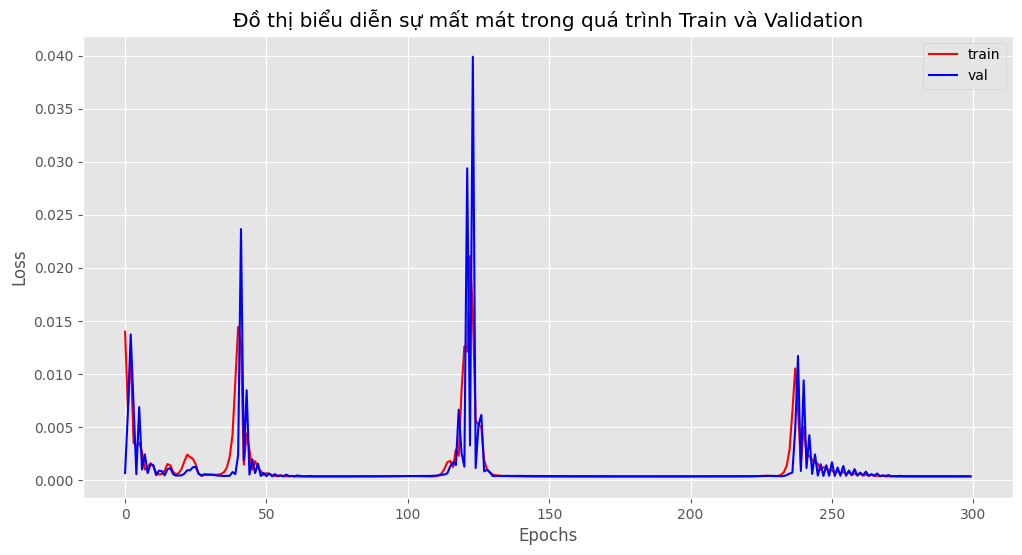

In [ ]:
timesteps = 60
hl = [35,35]
lr = 0.006202640842438905
batch_size = 64
num_epochs = 300

model, train_error, val_error = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs)

# Đồ thị biểu diễn sự mất mát trong quá trình huấn luyện và kiểm tra
def plot_error(train_loss, val_loss):
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Đồ thị biểu diễn sự mất mát trong quá trình Train và Validation')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()
plot_error(train_error, val_error)

#ĐÁNH GIÁ KẾT QUẢ

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MSE = 0.001445433046798308
RMSE = 0.038018851203032264
MAPE = 0.015071375448554662
R-Squared Score = 0.9826744442693763


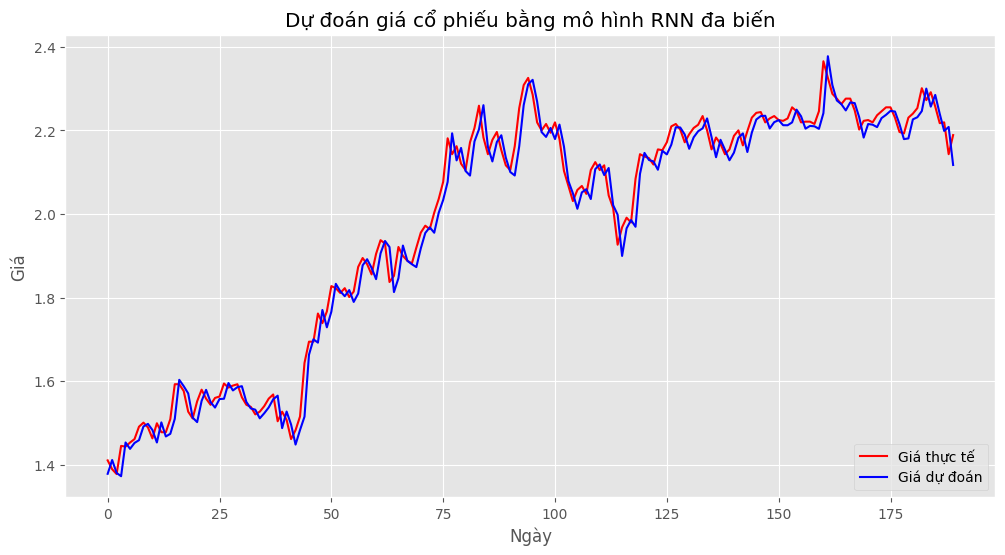

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model(model, test, timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

def plot_data(Y_test, Y_hat):
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test, color='r', label='Giá thực tế')
    plt.plot(Y_hat, color='b', label='Giá dự đoán')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
    plt.title("Dự đoán giá cổ phiếu bằng mô hình RNN đa biến")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
plot_data(true, predicted)

In [ ]:
# Tạo bảng so sánh giá trị thực tế và dự đoán
result_df = pd.DataFrame({
    'Actual': true.flatten(),
    'Predicted': predicted.flatten()
})

result_df['Giá thực tế'] = sc.inverse_transform(result_df[['Actual']])
result_df['Giá dự đoán'] = sc.inverse_transform(result_df[['Predicted']])
result_df['Chênh lệch'] = result_df['Giá thực tế'] - result_df['Giá dự đoán']
result_df = result_df.drop(columns=['Actual', 'Predicted'])

print("Bảng so sánh giá trị thực tế và dự đoán (Đơn vị: nghìn đồng):")
print(result_df.head(16))

Bảng so sánh giá trị thực tế và dự đoán (Đơn vị: nghìn đồng):
    Giá thực tế  Giá dự đoán  Chênh lệch
0         90.82    89.138504    1.681496
1         89.71    90.865616   -1.155616
2         89.11    89.250328   -0.140328
3         92.63    88.838554    3.791446
4         92.54    93.058655   -0.518655
5         93.05    92.258705    0.791295
6         93.48    92.997551    0.482449
7         95.03    93.346741    1.683259
8         95.54    95.061996    0.478004
9         94.94    95.382782   -0.442782
10        93.57    94.623383   -1.053383
11        95.46    93.057205    2.402795
12        94.34    95.569115   -1.229115
13        94.34    93.808304    0.531696
14        95.97    94.137894    1.832106
15       100.34    96.007263    4.332737
